In [1]:
!pip install torch==1.11.0

# 1 Import package

In [2]:
# import open method from io toolkit
from io import open
# for character normalization
import unicodedata
# for regular expressions
import re
# for random data generation
import random
# import torch toolkit for building network structures and functions
import torch
import torch.nn as nn
import torch.nn.functional as F
# import toolkit of predefined optimization methods in torch
from torch import optim
# device selection, choose to run the code on cuda or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2 Data Preprocessing

# 2.1 Mapping words in a given language to values

In [3]:
# start sign
SOS_token = 0
# end sign
EOS_token = 1

class Lang:
    def __init__(self, name):
        """The parameter 'name' in the initialization function represents the name of a language passed in"""
        # pass the name into the class
        self.name = name
        # initialize the dictionary of words corresponding to natural values
        self.word2index = {}
        # initialize the dictionary of natural values corresponding to the vocabulary, where 0, 1 corresponding to SOS and EOS are already in it
        self.index2word = {0: "SOS", 1: "EOS"}
        # initialize the index of the natural number corresponding to the vocabulary, starting from 2 here, because 0, 1 are already occupied by the start and end flags
        self.n_words = 2  

    def addSentence(self, sentence):
        """Add a sentence function, which converts a sentence into a sequence of values, with the input parameter 'sentence' being a sentence"""
        # segment the sentences according to the language characteristics of the country in general (the languages here are divided into words by spaces), and obtain the corresponding list of words
        for word in sentence.split(' '):
            # call addWord for processing
            self.addWord(word)


    def addWord(self, word):
        """Add a vocabulary function, which converts a vocabulary into a corresponding value, with the input parameter 'word' being a word"""
        # determine if the word is already in the key of the self.word2index dictionary
        if word not in self.word2index:
            # if not, add this word to the dictionary, and assign a value to this word, i.e. self.n_words
            self.word2index[word] = self.n_words
            # add its inverted form to self.index2word simultaneously
            self.index2word[self.n_words] = word
            # if self.n_words is occupied, add 1 each time to turn it into a new self.n_words
            self.n_words += 1

*Instantiate parameters*

In [4]:
name = "eng"

*Input Parameters*

In [5]:
sentence = "hello I am Jay"

*Call*

In [6]:
engl = Lang(name)
engl.addSentence(sentence)
print("word2index:", engl.word2index)
print("index2word:", engl.index2word)
print("n_words:", engl.n_words)

word2index: {'hello': 2, 'I': 3, 'am': 4, 'Jay': 5}
index2word: {0: 'SOS', 1: 'EOS', 2: 'hello', 3: 'I', 4: 'am', 5: 'Jay'}
n_words: 6


## 2.2 Normalizing String

In [7]:
# converting unicode to Ascii (removing the accent marks in some languages: Ślusàrski)
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s):
    """String normalization function, parameter 's' represents the string passed in"""
    # make characters lowercase and remove whitespace on both sides, then use unicodeToAscii to remove accent marks
    s = unicodeToAscii(s.lower().strip())
    # add a space before the .!?
    s = re.sub(r"([.!?])", r" \1", s)
    # use regular expressions to replace all strings that are not upper and lower case letters and normal punctuation with spaces
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

*Input parameters*

In [8]:
s = "Are you kidding me?"

*Call*

In [9]:
nsr = normalizeString(s)
print(nsr)

are you kidding me ?


## 2.3 Loading the data from the persistence file into memory, and instantiating the *Lang* class

In [10]:
data_path = '/Users/zhangyuqian/Desktop/ML project/sample_data:eng-fra.txt'

def readLangs(lang1, lang2):
    """Read language function, parameter 'lang1' is the name of the source language, parameter 'lang2' is the name of the target language
       Returns the corresponding class Lang object and a list of language pairs"""
    # read language pairs from the file and store them in listlines with '/n' divisions
    lines = open(data_path, encoding='utf-8').\
        read().strip().split('\n')
    # normalize the sentences in the lines list and divide them by '\t' to form a sublist, i.e., a language pair
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines] 
    # pass the language name into the Lang class, get the corresponding language object, and return the result
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

*Input Parameters*

In [11]:
lang1 = "eng"
lang2 = "fra"

*Call*

In [12]:
input_lang, output_lang, pairs = readLangs(lang1, lang2)
print("input_lang:", input_lang)
print("output_lang:", output_lang)
print("The first five in pairs:", pairs[:5])

input_lang: <__main__.Lang object at 0x7fca07842280>
output_lang: <__main__.Lang object at 0x7fca078422e0>
The first five in pairs: [['go .', 'va !'], ['run !', 'cours !'], ['run !', 'courez !'], ['wow !', 'ca alors !'], ['fire !', 'au feu !']]


## 2.4 Filtering out the language pairs that meet the requirements

In [13]:
# set the maximum number of words or punctuation in a sentence
MAX_LENGTH = 10

# select linguistic feature data with specified prefixes as training data
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    """Language pair filter function, the parameter 'p' represents the input language pair, such as ['she is afraid.', 'elle malade.']"""
    # p[0] represents an English sentence, which should be divided by a length less than MAX_LENGTH and start with the specified prefix
    # p[1] represents a French sentence, which should be divided in such a way that its length is less than MAX_LENGTH
    return len(p[0].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes) and \
        len(p[1].split(' ')) < MAX_LENGTH 


def filterPairs(pairs):
    """Filter on a list of language pairs, the parameter 'pairs' represents a list of language pairs, abbreviated as language pair list"""
    # function directly traverses each language pair in the list and calls filterPair
    return [pair for pair in pairs if filterPair(pair)]

*Input parameters*

In [14]:
# here, use the output of the readLangs function pairs as the input parameter pairs 

*Call*

In [15]:
fpairs = filterPairs(pairs)
print("The first five in filtered pairs:", fpairs[:5])

The first five in filtered pairs: [['i m .', 'j ai ans .'], ['i m ok .', 'je vais bien .'], ['i m ok .', 'ca va .'], ['i m fat .', 'je suis gras .'], ['i m fat .', 'je suis gros .']]


## 2.5 Integrating the data preparation functions shown above, and mapping the language pairs to values using the *Lang* class

In [16]:
def prepareData(lang1, lang2):
    """Data preparation function, which completes the mapping of all string data to numeric data and the filtering of language pairs
       The parameters 'lang1', 'lang2' represent the names of the source and target languages respectively"""
    # first, obtain the input_lang, output_lang objects and a list of language pairs of the string type through the readLangs function
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    # filter lists for string type languages
    pairs = filterPairs(pairs)
    # traverse the list for the filtered language
    for pair in pairs:
        # use the addSentence methods of input_lang and output_lang for numerical mapping
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    # return the value mapped object and the filtered language pair
    return input_lang, output_lang, pairs

*Call*

In [17]:
input_lang, output_lang, pairs = prepareData('eng', 'fra')
print("input_n_words:", input_lang.n_words)
print("output_n_words:", output_lang.n_words)
print(random.choice(pairs))

input_n_words: 2803
output_n_words: 4345
['i m impatient .', 'je suis impatient .']


## 2.6 Transform the language pairs into the tensor needed for model input

In [18]:
def tensorFromSentence(lang, sentence):
    """Convert a text sentence to a tensor, the parameter 'lang' represents the instantiated object of the Lang passed in, sentence is the pre-converted sentence"""
    # segment the sentence and traverse each word, then use word2index method of 'lang' to find its corresponding index
    # we can obtain the list of values corresponding to the sentence
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    # add the end-of-sentence marker
    indexes.append(EOS_token)
    # wrap it as a tensor using torch.tensor, and change its shape to nx1 to facilitate subsequent calculations
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    """Convert a language pair to a tensor pair, with parameter 'pair' as a language pair"""
    # call tensorFromSentence to process the source language and the target language separately to obtain the corresponding tensor representation
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    # return the tuple
    return (input_tensor, target_tensor)

*Input parameters*

In [19]:
# the first entry of pairs
pair = pairs[0]

*Call*

In [20]:
pair_tensor = tensorsFromPair(pair)
print(pair_tensor)

(tensor([[2],
        [3],
        [4],
        [1]]), tensor([[2],
        [3],
        [4],
        [5],
        [1]]))


# 3 Building GRU-based encoders and decoders

## 3.1 Building a GRU-based encoder

In [21]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        """There are two initialization parameters: 'input_size' represents the input size of the decoder, 
        i.e. the word list size of the source language; 'hidden_size' represents the number of hidden 
        nodes of GRU, which also represents the word embedding dimension, and is also the input size of GRU."""
        super(EncoderRNN, self).__init__()
        # pass the parameter 'hidden_size' into the class
        self.hidden_size = hidden_size
        # instantiate the predefined Embedding layer in nn, whose parameters are input_size, hidden_size
        # the word embedding dimension here is hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # instantiate the predefined GRU layer in nn, whose parameter is hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        """There are two parameters in the encoder forward logic function: 'input' represents the input tensor 
        of the Embedding layer of the source language; hidden represents the initial hidden layer tensor of the 
        encoder layer gru"""
        # embed the input tensor, and make its shape (1, 1, -1), -1 means the dimension is calculated automatically
        # theoretically, the encoder takes only one word at a time as input, so the size of the mapped vocabulary should be [1, embedding]
        # the reason for the conversion to 3D is that the predefined gru in the torch must use a 3D tensor as input, so expand it by one dimension
        output = self.embedding(input).view(1, 1, -1)
        # then, pass in the output of the embedding layer and the initial hidden as input to gru 
        # get the output of the final gru and the corresponding hidden tensor hidden, and return the result
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        """Initialize the hidden tensor function"""
        # initialize the hidden tensor to a 0 tensor of size 1 * 1 * self.hidden_size
        return torch.zeros(1, 1, self.hidden_size, device=device)

*Instantiate parameters*

In [22]:
hidden_size = 25
input_size = 20

*Input parameters*

In [23]:
# pair_tensor[0] represents the sentence in the source language, i.e. English, and pair_tensor[0][0] represents the first word in the sentence
input = pair_tensor[0][0]
# initialize the first hidden tensor, a 0 tensor of 1 * 1 * hidden_size
hidden = torch.zeros(1, 1, hidden_size)

*Call*

In [24]:
encoder = EncoderRNN(input_size, hidden_size)
encoder_output, hidden = encoder(input, hidden)
print(encoder_output)

tensor([[[-0.2365, -0.4685,  0.3727,  0.2041,  0.5849,  0.3269, -0.4125,
          -0.2622,  0.4215,  0.2241, -0.3261,  0.4786,  0.3804, -0.4119,
           0.0825, -0.2612, -0.5668, -0.0293,  0.1895, -0.0863, -0.2056,
          -0.3240, -0.3006, -0.0553,  0.0500]]], grad_fn=<StackBackward0>)


## 3.2 Building a GRU-based decoder

In [25]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        """There are two parameters in the initialization function, 
        'hidden_size' represents the input size of GRU in the decoder and also the number of its hidden layer nodes
        'output_size' represents the output size of the whole decoder, which is also the size we want to get, i.e. the word list size of the target language."""
        super(DecoderRNN, self).__init__()
        # pass the hidden_size into the class
        self.hidden_size = hidden_size
        # instantiate an Embedding layer object in nn, whose parameter output here represents the word list size of the target language
        # 'hidden_size' indicates the word embedding dimension of the target language
        self.embedding = nn.Embedding(output_size, hidden_size)
        # instantiate the GRU object with the input parameter hidden_size, which means its input size is the same as the number of hidden nodes
        self.gru = nn.GRU(hidden_size, hidden_size)
        # instantiate a linear layer, making linear changes to the output of GRU
        self.out = nn.Linear(hidden_size, output_size)
        # process with softmax for classification
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, input, hidden):
        """There are two parameters in the forward logic function of the decoder: 
        'input' represents the input tensor of the Embedding layer of the target language
        'hidden' represents the initial hidden layer tensor of the decoder GRU"""
        # embed the input tensor, and make its shape (1, 1, -1). -1 means the dimension is calculated automatically
        output = self.embedding(input).view(1, 1, -1)
        # process the output using the relu function to make the Embedding matrix more sparse to prevent overfitting
        output = F.relu(output)
        # pass the output of the embedding and the initialized hidden tensor to the decoder gru
        output, hidden = self.gru(output, hidden)
        # it can be downscaled by output[0], for the output of GRU is also a three-dimensional tensor where the first dimension is meaningless
        # pass it to the linear layer for transformation, and process it with softmax for classification.
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        """Initialize the hidden tensor function"""
        # initialize the hidden tensor to a 0 tensor of size 1 * 1 * self.hidden_size
        return torch.zeros(1, 1, self.hidden_size, device=device)

*Instantiate parameters*

In [26]:
hidden_size = 25
output_size = 10

*Input parameters*

In [27]:
# pair_tensor[1] represents the sentence in the target language, i.e. French, and pair_tensor[1][0] represents the first word in the sentence
input = pair_tensor[1][0]
# Initialize the first hidden tensor, a 0 tensor of 1 * 1 * hidden_size
hidden = torch.zeros(1, 1, hidden_size)

*Call*

In [28]:
decoder = DecoderRNN(hidden_size, output_size)
output, hidden = decoder(input, hidden)
print(output)

tensor([[-2.1861, -2.3541, -2.5320, -2.2448, -2.4298, -2.2694, -2.2059, -2.4538,
         -2.0324, -2.4228]], grad_fn=<LogSoftmaxBackward0>)


## 3.3 Building decoder based on GRU and Attention

In [29]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        """There are 4 parameters in the initialization function:
        'hidden_size' represents the input size of GRU in the decoder and also the number of its hidden layer nodes
        'output_size' represents the output size of the whole decoder, i.e. the word list size of the target language.
        'dropout_p' represents the zeroing ratio when we use the dropout layer, default 0.1, max_length represents the maximum length of the sentence"""
        super(AttnDecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # instantiate an Embedding layer, with input parameters self.output_size and self.hidden_size
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # according to the QKV theory of attention, the input parameters of attention are three Q, K, V
        # attention weights are calculated using Q and K to obtain the weight matrix, and then matrix multiplication is done with V to obtain the attentional representation of V.
        # stitch Q and K together on the vertical axis, perform the linear variation once, obtain the result by softmax processing, and make a tensor multiplication with V
        
        # need a matrix for linear transformation, instantiate nn.Linear
        # since its input is a splice of Q, K, the first parameter is self.hidden_size * 2, and the second parameter is self.max_length
        # Here, Q is the output of the Embedding layer of the decoder, K is the hidden layer output of the GRU of the decoder
        # V is the output of the encoder layer
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        # Next, instantiate another linear layer, which is used to normalize the output size
        # the input dimension is self.hidden_size * 2
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        # Next, instantiate a nn.Dropout layer and pass in self.dropout_p
        self.dropout = nn.Dropout(self.dropout_p)
        # then, instantiate nn.GRU of which input and hidden layer size are both self.hidden_size
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        # Finally instantiate the linear layer behind gru, which is the decoder output layer.
        self.out = nn.Linear(self.hidden_size, self.output_size)


    def forward(self, input, hidden, encoder_outputs):
        """There are 3 input parameters in the forward function: 
        the source data input tensor, the initial hidden tensor, and the output tensor of the decoder"""

        # subject the input tensor to Embedding layers, and expand dimensionality
        embedded = self.embedding(input).view(1, 1, -1)
        # use dropout for random discarding to prevent overfitting
        embedded = self.dropout(embedded)

        # stitch Q, K on the vertical axis, make a linear change, and use softmax processing.
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)

        # perform the bmm operation
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # reduce the dimensionality by taking [0], and splice Q with the calculation result of the previous step again
        output = torch.cat((embedded[0], attn_applied[0]), 1)

        # use the linear layer action to perform a linear transformation on the result of the previous step, and extend the dimensionality
        output = self.attn_combine(output).unsqueeze(0)

        # activate with relu
        output = F.relu(output)

        # pass in the result after the activation as input to gru along with hidden
        output, hidden = self.gru(output, hidden)

        # downscale the results, and process them with softmax
        output = F.log_softmax(self.out(output[0]), dim=1)
        # return the decoder result, the final hidden layer tensor, and the attention weight tensor
        return output, hidden, attn_weights

    def initHidden(self):
        """Initialize the hidden tensor function"""
        # initialize the hidden tensor to a 0 tensor of size 1 * 1 * self.hidden_size
        return torch.zeros(1, 1, self.hidden_size, device=device)

*Instantiate parameters*

In [30]:
hidden_size = 25
output_size = 10

*Input parameters*

In [31]:
input = pair_tensor[1][0]
hidden = torch.zeros(1, 1, hidden_size)
# encoder_outputs needs to be a stack of outputs for each time step in the encoder
# its shape should be 10x25, so directly initialize a tensor here at random
encoder_outputs  = torch.randn(10, 25)

*Call*

In [32]:
decoder = AttnDecoderRNN(hidden_size, output_size)
output, hidden, attn_weights= decoder(input, hidden, encoder_outputs)
print(output)

tensor([[-2.1850, -2.0518, -2.1782, -2.4231, -2.2649, -2.3744, -2.4032, -2.4213,
         -2.4086, -2.3964]], grad_fn=<LogSoftmaxBackward0>)


# 4 Construct model training function and perform training

## 4.1 Constructing training functions

In [33]:
# set the teacher_forcing ratio to 0.5
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    """There are 8 input parameters in the training function: 
    input_tensor: input tensor of the source language,
    target_tensor: target language input tensor, and
    encoder, decoder: encoder and decoder instantiation objects,
    encoder_optimizer, decoder_optimizer: encoder and decoder optimization methods, 
    criterion: loss function calculation method, and
    max_length: the maximum length of the sentence"""

    # initialize the hidden tensor
    encoder_hidden = encoder.initHidden()

    # encoder and decoder optimizer gradient to 0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # obtain the corresponding lengths based on the source and target text tensor
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # initialize the encoder output tensor in the shape of a 0-tensor of max_length * encoder.hidden_size
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # initialize set loss to 0
    loss = 0

    # traverse the input tensor index
    for ei in range(input_length):
        # extract the tensor representation of the corresponding word from the input_tensor according to the index 
        # and pass it into the encoder object together with the initialized hidden tensor
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        # store the output of encoder_output (3D tensor) and its vectorized form into encoder_outputs
        encoder_outputs[ei] = encoder_output[0, 0]

    # initialize the first input of the decoder, i.e. start sign
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # initialize the implicit tensor of the decoder, i.e. the implicit output of the encoder
    decoder_hidden = encoder_hidden

    # determine whether to use teacher_forcing based on the random number compared to teacher_forcing_ratio
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # if use teacher_forcing
    if use_teacher_forcing:
        # traverse the target tensor index
        for di in range(target_length):
            # pass decoder_input, decoder_hidden, encoder_outputs (Q, K, V in attention) into decoder to obtain decoder_output, decoder_hidden, decoder_attention
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # due to the use of teacher_forcing, we only use target_tensor[di] to calculate the loss regardless of the decoder_output of the decoder
            loss += criterion(decoder_output, target_tensor[di])
            # meanwhile, force the next decoder input to be set to 'the correct answer'
            decoder_input = target_tensor[di]  

    else:
        # if not use teacher_forcing
        # still traverse the target tensor index
        for di in range(target_length):
            # pass decoder_input, decoder_hidden, encoder_outputs into decoder to obtain decoder_output, decoder_hidden, decoder_attention
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # here, get the answer from decoder_output
            topv, topi = decoder_output.topk(1)
            # still use decoder_output and target_tensor[di] as the loss calculation 
            loss += criterion(decoder_output, target_tensor[di])
            # if the output value is a terminator, the loop stops
            if topi.squeeze().item() == EOS_token:
                break
            # otherwise, descend the topi and separate the value to decoder_input for the next operation
            # the detachment of the detachment here makes this decoder_input independent of the tensor map constructed by the model, 
            # equivalent to a completely new external input
            decoder_input = topi.squeeze().detach()


    # back propagation of errors
    loss.backward()
    # optimize encoders and decoders are optimized i.e. update parameters
    encoder_optimizer.step()
    decoder_optimizer.step()

    # return average loss
    return loss.item() / target_length

## 4.2 Constructing time calculation functions

In [34]:
import time
import math

def timeSince(since):
    "Get the training elapsed time per print, 'since' represents the training start time"
    # get current time
    now = time.time()
    # get the time difference (training time consuming)
    s = now - since
    # convert seconds to minutes, and round to the nearest whole number
    m = math.floor(s / 60)
    # calculate the number of seconds left to make up the 1 minute
    s -= m * 60
    # returns the elapsed time for the specified format
    return '%dm %ds' % (m, s)

*Input parameters*

In [35]:
# assume that the model training starts 10min before
since = time.time() - 10*60

*Call*

In [36]:
period = timeSince(since)
print(period)

10m 0s


## 4.3 Calling training functions and printing logs and graphing

In [37]:
import matplotlib.pyplot as plt

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    """There are 6 input parameters in the training iteration function, namely:
    encoder, decoder: encoder and decoder objects.
    n_iters: the total number of iterative steps, 
    print_every: print log interval, 
    plot_every: interval to plot the loss curve, 
    learning_rate"""
    # get training start time stamp
    start = time.time()
    # average loss saving list for each loss interval for plotting loss curves
    plot_losses = []

    # total loss per print log interval, initially 0
    print_loss_total = 0  
    # total loss for each plotted loss interval, initially 0
    plot_loss_total = 0  

    # use the predefined SGD as an optimizer, pass the parameters and learning rate into it
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # select the loss function
    criterion = nn.NLLLoss()

    # loop according to set iteration step
    for iter in range(1, n_iters + 1):
        # randomly select from the list of language pairs as a training statement one at a time
        training_pair = tensorsFromPair(random.choice(pairs))
        # take the input tensor and target tensor from training_pair respectively
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        # obtain the loss of the model run by the train function
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        # sum up losses
        print_loss_total += loss
        plot_loss_total += loss

        # when the iteration step reaches the log printing interval
        if iter % print_every == 0:
            # obtain average loss through dividing the total loss by the interval
            print_loss_avg = print_loss_total / print_every
            # reset the total loss to zero
            print_loss_total = 0
            # print the logs with the following contents: 
            # training time, current iteration step, current progress percentage, current average loss
            print('%s (%d %d%%) %.4f' % (timeSince(start),
                                         iter, iter / n_iters * 100, print_loss_avg))

        # when the iteration step reaches the loss drawing interval
        if iter % plot_every == 0:
            # obtain Average loss through dividing the total loss by the interval
            plot_loss_avg = plot_loss_total / plot_every
            # load the average loss into the plot_losses list
            plot_losses.append(plot_loss_avg)
            # reset total loss to 0
            plot_loss_total = 0

    # plot loss curves
    plt.figure()  
    plt.plot(plot_losses)
    # save to specified path
    plt.savefig("./s2s_loss.png")

*Input parameters*

In [38]:
# set the hidden layer size to 256, which is also the word embedding dimension      
hidden_size = 256
# get the total number of input words by input_lang.n_words and pass it to EncoderRNN class together with hidden_size
# get encoder object encoder1
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)

# get the total number of target words by output_lang.n_words and pass it into AttnDecoderRNN class together with hidden_size and dropout_p
# get decoder object attn_decoder1
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

# set the number of iteration steps 
n_iters = 75000
# set the log printing interval
print_every = 5000 

*Call*

3m 36s (5000 6%) 3.4072
7m 18s (10000 13%) 2.7983
10m 58s (15000 20%) 2.4237
14m 39s (20000 26%) 2.1756
18m 21s (25000 33%) 1.9500
22m 7s (30000 40%) 1.8002
25m 53s (35000 46%) 1.6398
29m 35s (40000 53%) 1.5193
33m 24s (45000 60%) 1.4244
37m 12s (50000 66%) 1.2928
40m 54s (55000 73%) 1.2234
44m 40s (60000 80%) 1.1583
48m 23s (65000 86%) 1.0771
52m 8s (70000 93%) 1.0315
55m 52s (75000 100%) 0.9732


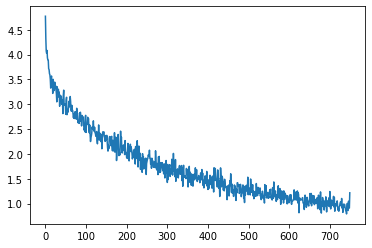

In [39]:
# call trainIters for model training, pass encoder object encoder1, coder object attn_decoder1, number of iteration steps, log printing interval into it
trainIters(encoder1, attn_decoder1, n_iters, print_every=print_every)

# 5 Construct model evaluation functions and perform testing and Attention effect analysis

## 5.1 Constructing model evaluation functions

In [40]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    """There are 4 input parameters in the evaluation function, which are:
    encoder, decoder: encoder and decoder objects,
    sentence: the sentence to be evaluated.
    max_length: the maximum length of the sentence"""

    # no gradient calculation in the evaluation phase
    with torch.no_grad():
        # tensor representation of the input sentences
        input_tensor = tensorFromSentence(input_lang, sentence)
        # get the input sentence length
        input_length = input_tensor.size()[0]
        # initialize the encoder hidden tensor
        encoder_hidden = encoder.initHidden()

        # initialize the encoder output tensor to be a 0-tensor of max_lengthxencoder.hidden_size
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # iterate through the input tensor index
        for ei in range(input_length):
             # extract the tensor representation of the corresponding word from the input_tensor according to the index 
             # and pass it into the encoder object together with the initialized hidden tensor
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            # store the output of encoder_output (3D tensor) and its vectorized form into encoder_outputs
            encoder_outputs[ei] += encoder_output[0, 0]

        # initialize the first input of the decoder, i.e. the start sign
        decoder_input = torch.tensor([[SOS_token]], device=device) 
        # initialize the implicit tensor of the decoder, i.e. the implicit output of the encoder
        decoder_hidden = encoder_hidden

        # initialize the list of predicted words
        decoded_words = []
        # initialize the attention tensor
        decoder_attentions = torch.zeros(max_length, max_length)
        # start loop decoding
        for di in range(max_length):
            # pass decoder_input, decoder_hidden, encoder_outputs into decoder to obtain decoder_output, decoder_hidden, decoder_attention
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            # take all the attention results and store them in the initialized attention tensor
            decoder_attentions[di] = decoder_attention.data
            # obtain the value with the highest probability and its index object from the decoder output
            topv, topi = decoder_output.data.topk(1)
            # take the value from the index object and compare it with the end flag value
            if topi.item() == EOS_token:
                # if it is the end flag value, load the end flag into the decoded_words list (the end of translation)
                decoded_words.append('<EOS>')
                # exit loop
                break

            else:
                # otherwise, find its corresponding word in the index2word dictionary of the output language according to the index and load it into decoded_words
                decoded_words.append(output_lang.index2word[topi.item()])

            # deal the index of this prediction by dimensionality reduction, and ssign it to the decoder_input for the next prediction
            decoder_input = topi.squeeze().detach()
        # return the result decoded_words and the full attention tensor, and cut out the unused parts
        return decoded_words, decoder_attentions[:di + 1]

## 5.2 Randomly select a specified amount of data for evaluation

In [41]:
def evaluateRandomly(encoder, decoder, n=6):
    """Randomly evaluate function, input parameters 'encoder' and 'decoder' represents the encoder and decoder objects, 
    n represents the number of tests"""
    # loop for test numbers
    for i in range(n):
        # randomly select language pairs from pairs
        pair = random.choice(pairs)
        # > represents input
        print('>', pair[0])
        # = represents the correct output
        print('=', pair[1])
        # call evaluate for prediction
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        # connect the results into sentences
        output_sentence = ' '.join(output_words)
        # < represents the output of the model
        print('<', output_sentence)
        print('')

*Call*

In [57]:
# call evaluateRandomly for model testing
evaluateRandomly(encoder1, attn_decoder1)

> i m not even a little hungry .
= je n ai pas faim du tout .
< je n ai pas faim de faim . <EOS>

> he is a lazy fellow .
= c est un type paresseux .
< c est une femme paresseux . <EOS>

> i m feeling much better today .
= je me sens beaucoup mieux aujourd hui .
< je me sens beaucoup mieux aujourd hui . <EOS>

> i am afraid to go .
= j ai peur d y aller .
< j ai peur de m y rendre . <EOS>

> i am paid weekly .
= je suis payee a la semaine .
< je suis en le . <EOS>

> we re not getting any younger .
= nous ne rajeunissons pas .
< nous ne rajeunissons pas . <EOS>



## 5.3 Visualizing Attention tensor

['nous', 'sommes', 'tous', 'deux', 'enseignants', '.', '<EOS>']


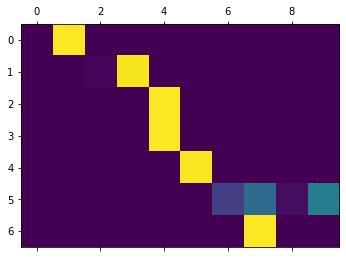

In [72]:
sentence = "we re both teachers ."
# call the evaluation function
output_words, attentions = evaluate(encoder1, attn_decoder1, sentence)
print(output_words)
# convert attention tensor to numpy, use matshow to plot
plt.matshow(attentions.numpy())
# save image
plt.savefig("./s2s_attn.png")